hydrogen playtime

In [2]:
%matplotlib notebook
%matplotlib inline
from scipy.linalg import eigh
import matplotlib.pyplot as plt 
from scipy.integrate import odeint
import rootfinder as rtf
import numpy as np
import scipy as sci
from scipy.fft import fft, ifft
from scipy.linalg import solve
from numba import jit
from Particle1D import Pendulum
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import math

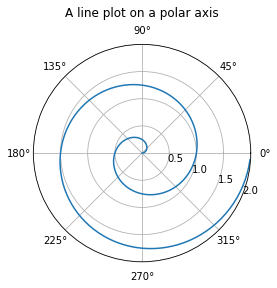

In [3]:
r = np.arange(0, 2, 0.01)
theta = 2 * np.pi * r
ax = plt.subplot(111, projection='polar')
ax.plot(theta, r)
ax.set_rmax(2)
ax.set_rticks([0.5, 1, 1.5, 2])  # Less radial ticks
ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
ax.grid(True)

ax.set_title("A line plot on a polar axis", va='bottom')
plt.show()

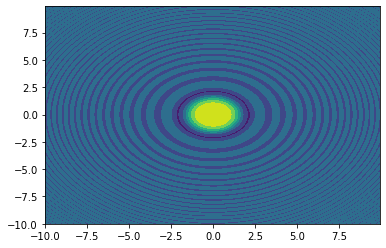

In [4]:
x = np.arange(-10, 10, 0.1)
y = np.arange(-10, 10, 0.1)
xx, yy = np.meshgrid(x, y, sparse=True)
z = np.sin(xx**2 + yy**2) / (xx**2 + yy**2)
h = plt.contourf(x,y,z)
plt.show()

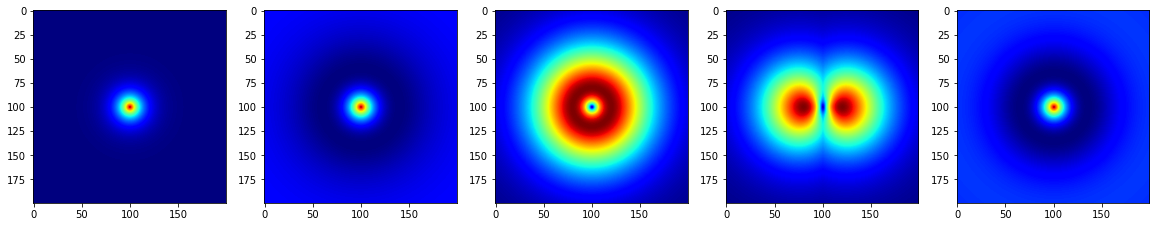

In [5]:

r = np.sqrt(xx**2 + yy**2)
phi = np.arctan(yy/xx)
theta = np.pi/2


psi100 = (1/np.sqrt(4*np.pi))*np.exp(-r)
psi200 = (1/np.sqrt(4*np.pi))*(2-r)*np.exp(-r/2)
psi210 = (1/np.sqrt(16*np.pi))*np.cos(theta)*r*np.exp(-r/2)
psi211 = np.exp(np.cos(phi))*np.sin(theta)*r*np.exp(-r/2)
psi300 = (1/81)*(27-18*r+2*(r**2))*np.exp(-r/3)

plt.figure(figsize = (20,10))
plt.subplot(1,5,1)
plt.imshow(psi100, cm.jet)
plt.subplot(1,5,2)
plt.imshow(psi200, cm.jet)
plt.subplot(1,5,3)
plt.imshow(psi210, cm.jet)
plt.subplot(1,5,4)
plt.imshow(psi211, cm.jet)
plt.subplot(1,5,5)
plt.imshow(psi300, cm.jet)

###the first few solutions for the hydrogen atom, scaled badly but the general shape is this.


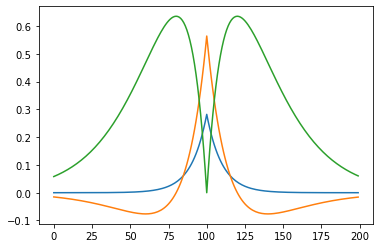

In [49]:
plt.plot(psi100[100,:])
plt.plot(psi200[100,:])
plt.plot((1e17)*psi210[100,:])

can i use monte carlo to get the first few energies AND the first few wavefunctions?
then i can scale it up to He?

ack
ok so i think the way to do it is always to just have a trial and variationally determine hella parameters by energy minimization.
maybe i can do hydrogen w pretty pictures as fluff, then do helium to be like ok that's why we're doin this because in THIS case u can't even do it analytically

so, i could do hydrogen then helium, or maybe helium and then helium in a mag field, or something, or lithium, or somethin

In [60]:
import numpy as np
import matplotlib.pyplot as plt
import math

#Define trial function
def wf(r,alpha,a,b,c):
    '''Computes the trial wavefunction'''
    r_norm = np.linalg.norm(r)
    wf = (a+b*r_norm+c*(r_norm**2))*np.exp(-alpha*r_norm)
    return wf

#define prob density
def prob_density(r,alpha,a,b,c):
    '''Computes the probability density (not normalized) of the trial 
    wavefunction'''
    return wf(r,alpha,a,b,c)**2

#define E local
def E_local(r,alpha,a,b,c):
    '''Computes the local energy, in terms of r1, r2 and alpha, corresponding
    to the trial wavefunction'''
    r_norm = np.linalg.norm(r)
    # energy = -1/r_norm-alpha*(alpha-2/r_norm)/2
    #energy = -1/r_norm - (alpha**2)/2 -alpha/(2-r_norm) + alpha/r_norm + 1/(r_norm*(2-r_norm))
    #energy = -1/r_norm -(alpha**2)/2 -(b*alpha)/(c-b*r_norm) + alpha/r_norm +b/(r_norm*(c-b*r_norm))
    energy = -1/r_norm -(alpha**2)/2 + alpha/r_norm + (alpha*(2*c*r_norm+b)+c)/(a+b*r_norm+c*(r_norm**2)) - (2*c*r_norm+b)/(r_norm*(a+b*r_norm+c*(r_norm**2)))
    return energy 
    
    
def metropolis(N, alpha,a,b,c):
    '''Metropolis algorithm that takes N steps. We start with two random 
    variable within the typical length of the problem and then we create a 
    Markov chain taking into account the probability density. At each step we
    compute the parameters we are interested in.'''
        
    L = 2
    r = (np.random.rand(3)*2*L-L)
    E = 0
    E2 = 0 #it is going to be E**2 (useful to compute variance of energy)
    Eln_average = 0
    ln_average = 0
    rejection_ratio = 0
    #Algorithm
    for i in range(N):
        r_trial = r + 0.2*(np.random.rand(3)*2*L-L)
        if prob_density(r_trial,alpha,a,b,c) >= prob_density(r,alpha,a,b,c):
            r = r_trial
        else:
            dummy = np.random.rand()
            if dummy < prob_density(r_trial,alpha,a,b,c)/prob_density(r,alpha,a,b,c):
                r = r_trial
            else:
                rejection_ratio += 1/N
                
        E += E_local(r,alpha,a,b,c)/N
        E2 += E_local(r,alpha,a,b,c)**2/N
        Eln_average += E_local(r,alpha,a,b,c)*-np.linalg.norm(r)/N
        ln_average += -np.linalg.norm(r)/N
    
    return E, E2, Eln_average, ln_average, rejection_ratio

    
'''Initial parameters'''



#alpha = 0.6
#c=2
#b = 1

def MCMC_H(a,b,c,alpha):

    alpha_iterations = 10
    N_metropolis = 1000
    random_walkers = 200
    gamma = 0.5 


    energy_plot = np.array([])
    alpha_plot = np.array([])
    variance_plot = np.array([])

    for i in range(alpha_iterations):
        '''This loop iterates over alpha to find the value which minimizes the Energy.
        Apart from that, it calculates the rejection ratio and saves data needed for plotting'''
    
        E = 0
        E2 = 0
        dE_dalpha = 0
        Eln = 0
        ln = 0
        rejection_ratio = 0
        for j in range(random_walkers): #We use more than one random_walkers in case one gets stuck at some X
            E_met, E2_met, Eln_met, ln_met, rejections_met = metropolis(N_metropolis, alpha,a,b,c)
            E += E_met/random_walkers
            E2 += E2_met/random_walkers
            Eln += Eln_met/random_walkers
            ln += ln_met/random_walkers
            rejection_ratio += rejections_met/random_walkers
        
        print('Alpha: ', alpha, '<E>: ', E, 'VarE: ', E2-E**2, 'ratio = ', rejection_ratio)

        # Define next alpha
        #dE_dalpha = 2*(Eln-E*ln)
        #alpha = alpha - gamma*dE_dalpha #maybe change this so it's evenly spaced instead of adaptive
        alpha = alpha + .03
        # plots:    
        energy_plot = np.append(energy_plot, E)
        alpha_plot = np.append(alpha_plot, alpha)
        variance_plot = np.append(variance_plot, E2-E**2)
        
    return energy_plot, variance_plot, alpha_plot
    
    
###AND RUN IT TO OPTIMIZE ALPHA    
energy_plot, variance_plot, alpha_plot = MCMC_H(a = 1, b = -(2/3) ,c = (2/27), alpha = .21)

print('Done!')

## and is there a way to add in the l states?

##can i get the computer to do this derivative orrrrr liiiike


###ok!! the excited state w 2-r trial function actually legit works if u use 3000 metropolis iterations and evenly spaced alphas (.05, .3 start). 200 random walkers!
###the real min energy is somewhere between .45 and .5, but variance is like by far the least at .5 
##so it's a pretty good guess and even .45 is not bad. it also gets the energy correct (in HT units):-.125
##ok, trying 3,0,0, constants over 9. can it work with N=3000 and 200 rw

##let's move on to He and diffusion, maybe adding diffusion monte carlo w FNA and seeing how it compares to VMC.

Alpha:  0.1 <E>:  -0.19622178250136652 VarE:  0.28705633288085963 ratio =  0.12454500000000003
Alpha:  0.13 <E>:  -0.1586507691321875 VarE:  0.31195194899708667 ratio =  0.1403300000000001
Alpha:  0.16 <E>:  -0.17616072935546181 VarE:  0.26850503691108674 ratio =  0.13795500000000008
Alpha:  0.19 <E>:  -0.21413991680157607 VarE:  0.23537049479901817 ratio =  0.12548000000000015
Alpha:  0.22 <E>:  -0.1740553741938049 VarE:  0.2195137881366786 ratio =  0.13787000000000008
Alpha:  0.25 <E>:  -0.19133095857251983 VarE:  0.19344529226870916 ratio =  0.14359000000000005
Alpha:  0.28 <E>:  -0.15474621515473677 VarE:  0.21637269790234967 ratio =  0.15135500000000016
Alpha:  0.31000000000000005 <E>:  -0.16615206926839793 VarE:  0.19040632484952988 ratio =  0.15302000000000018
Alpha:  0.3400000000000001 <E>:  -0.13248259324976236 VarE:  0.18895942106815422 ratio =  0.1650150000000001
Alpha:  0.3700000000000001 <E>:  -0.16369706570309686 VarE:  0.16468839013750408 ratio =  0.16002000000000005
Don

Text(0, 0.5, 'Energy')

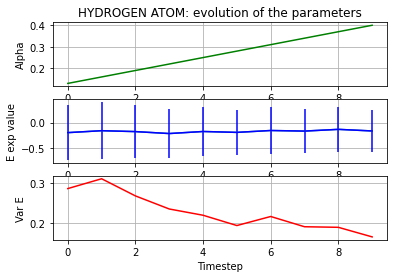

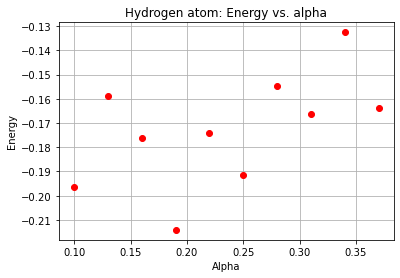

In [62]:
fig1 = plt.figure()

ax1 = fig1.add_subplot(311)
plt.title('HYDROGEN ATOM: evolution of the parameters')
plt.grid()
ax1.plot(alpha_plot, 'g')
ax1.set_xlabel('Timestep')
ax1.set_ylabel('Alpha')

ax2 = fig1.add_subplot(312)
plt.grid()
ax2.plot(energy_plot)
ax2.set_xlabel('Timestep')
ax2.set_ylabel('E exp value')
ax2.errorbar(range(len(energy_plot)), energy_plot, yerr=np.sqrt(variance_plot), c='b')

ax3 = fig1.add_subplot(313)
plt.grid()
ax3.plot(variance_plot, 'r')
ax3.set_xlabel('Timestep')
ax3.set_ylabel('Var E')

fig2 = plt.figure()
ax4 = fig2.add_subplot(111)
plt.title('Hydrogen atom: Energy vs. alpha')
plt.grid()
ax4.plot(alpha_plot-.03, energy_plot, 'ro')
ax4.set_xlabel('Alpha')
ax4.set_ylabel('Energy')




0.5000000000415854


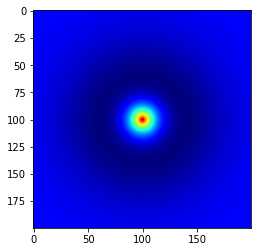

In [82]:
print(alpha)
psit_100 = np.exp(-r)
psit_200 = (2-r)*np.exp(-alpha*r)

plt.imshow(psit_200, cm.jet)

Alpha:  0 <E>:  -2.853290661525295 VarE:  0.23892825301044063 ratio =  0.36607999999999224
Alpha:  0.05 <E>:  -2.8705777715289527 VarE:  0.17541178019470038 ratio =  0.37569799999999126
Alpha:  0.1 <E>:  -2.8774631330947193 VarE:  0.13667581534445183 ratio =  0.38127799999999074
Alpha:  0.15000000000000002 <E>:  -2.8773017288645297 VarE:  0.1116027703192497 ratio =  0.38663899999999
Alpha:  0.2 <E>:  -2.879031222708102 VarE:  0.0966448938533695 ratio =  0.3900169999999897
Alpha:  0.25 <E>:  -2.873181842114629 VarE:  0.08829521986830358 ratio =  0.3939759999999892


Text(0, 0.5, 'Energy')

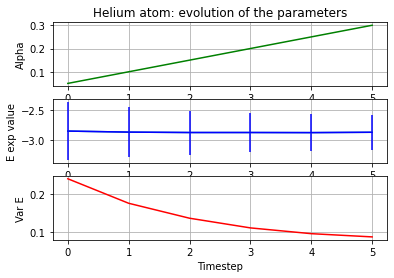

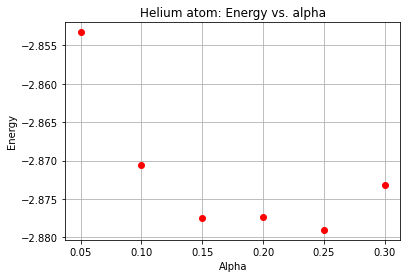

In [56]:
#Define trial function
def wf(r1,r2,alpha):
    '''Computes the trial wavefunction'''
    norm_r1 = np.linalg.norm(r1)
    norm_r2 = np.linalg.norm(r2)
    r12 = np.linalg.norm(r1-r2)
    wf = np.exp(-2*norm_r1)*np.exp(-2*norm_r2)*np.exp(r12/(2*(1+alpha*r12)))
    return wf

#define prob density
def prob_density(r1,r2,alpha):
    '''Computes the probability density (not normalized) of the trial wavefunction'''
    return wf(r1,r2,alpha)**2

#define E local
def E_local(r1,r2,alpha):
    '''Computes the local energy, in terms of r1, r2 and alpha, corresponding to the trial wavefunction'''
    norm_r1 = np.linalg.norm(r1)
    norm_r2 = np.linalg.norm(r2)
    r12 = np.linalg.norm(r1-r2)        
    dot_product = np.dot(r1/norm_r1-r2/norm_r2,r1-r2)
    energy = -4+dot_product/(r12*(1+alpha*r12)**2)-1/(r12*(1+alpha*r12)**3)-1/(4*(1+alpha*r12)**4)+1/r12 
    return energy
   
def metropolis(N, alpha):
    '''Metropolis algorithm that takes N steps. We start with two random variable within the
    typical length of the problem and then we create a Markov chain taking into account the 
    probability density. At each step we compute the parameters we are interested in.'''
        
    L = 1
    r1 = np.random.rand(3)*2*L-L
    r2 = np.random.rand(3)*2*L-L #random number from -L to L
    E = 0
    E2 = 0
    Eln_average = 0
    ln_average = 0
    rejection_ratio = 0
    step = 0
    max_steps = 500
    
    #Algorithm
    for i in range(N):
        chose = np.random.rand()
        step = step + 1
        if chose < 0.5:
            r1_trial = r1 + 0.5*(np.random.rand(3)*2*L-L)
            r2_trial = r2
        else:
            r2_trial = r2 + 0.5*(np.random.rand(3)*2*L-L)
            r1_trial = r1
        if prob_density(r1_trial,r2_trial,alpha) >= prob_density(r1,r2,alpha):
            r1 = r1_trial
            r2 = r2_trial
        else:
            dummy = np.random.rand()
            if dummy < prob_density(r1_trial,r2_trial,alpha)/prob_density(r1,r2,alpha):
                r1 = r1_trial
                r2 = r2_trial
            else:
                rejection_ratio += 1./N
                
        if step > max_steps:
            E += E_local(r1,r2,alpha)/(N-max_steps)
            E2 += E_local(r1,r2,alpha)**2/(N-max_steps)
            r12 = np.linalg.norm(r1-r2)
            Eln_average += (E_local(r1,r2,alpha)*-r12**2/(2*(1+alpha*r12)**2))/(N-max_steps)
            ln_average += -r12**2/(2*(1+alpha*r12)**2)/(N-max_steps)
            
    return E, E2, Eln_average, ln_average, rejection_ratio

'''Initial parameters'''
alpha = 0
#alpha_iterations = 30
alpha_iterations = 6
N_metropolis = 5000
random_walkers = 200
gamma = 0.5

energy_plot = np.array([])
alpha_plot = np.array([])
variance_plot = np.array([])

for i in range(alpha_iterations):
    E = 0
    E2 = 0
    dE_dalpha = 0
    Eln = 0
    ln = 0
    rejection_ratio = 0
    
    for j in range(random_walkers): #We use more than one random_walkers in case one gets stuck at some X
        E_met, E2_met, Eln_met, ln_met, rejections_met = metropolis(N_metropolis, alpha)
        E += E_met/random_walkers
        E2 += E2_met/random_walkers
        Eln += Eln_met/random_walkers
        ln += ln_met/random_walkers
        rejection_ratio += rejections_met/random_walkers 

    '''Define next alpha'''
    dE_dalpha = 2*(Eln-E*ln)
    print('Alpha: ', alpha, '<E>: ', E, 'VarE: ', E2-E**2, 'ratio = ', rejection_ratio)
    alpha = alpha + 0.05
    #alpha = alpha - gamma*dE_dalpha

    '''Plot'''    
    energy_plot = np.append(energy_plot, E)
    alpha_plot = np.append(alpha_plot, alpha)
    variance_plot = np.append(variance_plot, E2-E**2)


fig1 = plt.figure()

ax1 = fig1.add_subplot(311)
plt.title('Helium atom: evolution of the parameters')
plt.grid()
ax1.plot(alpha_plot, 'g')
ax1.set_xlabel('Timestep')
ax1.set_ylabel('Alpha')

ax2 = fig1.add_subplot(312)
plt.grid()
ax2.plot(energy_plot)
ax2.set_xlabel('Timestep')
ax2.set_ylabel('E exp value')
ax2.errorbar(range(len(energy_plot)), energy_plot, yerr=np.sqrt(variance_plot), c='b')

ax3 = fig1.add_subplot(313)
plt.grid()
ax3.plot(variance_plot, 'r')
ax3.set_xlabel('Timestep')
ax3.set_ylabel('Var E')

fig2 = plt.figure()
ax4 = fig2.add_subplot(111)
plt.title('Helium atom: Energy vs. alpha')
plt.grid()
ax4.plot(alpha_plot, energy_plot, 'ro')
ax4.set_xlabel('Alpha')
ax4.set_ylabel('Energy')

In [ ]:
##aight so this takes a long ass fuckin time to run, which is fine i guess
##try to add laguerre to hydrogen i guess.

In [ ]:
## make sure in both cases u compare to lit
##Include 1000-pt metropolis burn-in